In [1]:
####################################
########### LOAD PKGS ##############
####################################
%matplotlib tk
%autosave 180

#%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models



Autosaving every 180 seconds


In [2]:
####################################
########### LOAD RESNET ############
####################################
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)

# Not sure what this does
for param in model.parameters():
    param.requires_grad = False
    
# Note sure what this does, effect on fc layer?
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))

# todo: look up this loss
criterion = nn.NLLLoss()

# todo: look up this optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# move model to gpu
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
###################################################
##### LOAD PREVIOUSLY SAVED MODEL (OPTIONAL) ######
###################################################
fname = '/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/model_100epoch_Green3Chan_cnn_training_30mins_data.pt'
model.load_state_dict(torch.load(fname))
#model.eval()


<All keys matched successfully>

In [3]:
#################################################
########### MAKE DATA LOADER FUNCTION ###########
#################################################

# FUNCTION REQUIRED FOR TORCH (?) ALSO FOR RESNET fixed sizes
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.46, 0.48, 0.51], [0.32, 0.32, 0.32])
    ])

# DATA LOADER AND RANDOMIZER FUNCTION
def make_trainloader(train_data, 
                     vals, 
                     batch_size,
                     randomize=True):
    
    # RANDOMIZE DATA EVERYTIME THIS IS CALLED
    if randomize:
        idx = np.random.choice(np.arange(vals.shape[0]),
                         vals.shape[0],replace=False)
        # REARANGE DATA BASED ON RANDOMIZATION FLAG
        train_data = train_data[idx]
        vals = vals[idx]
    else:
        idx = np.arange(vals.shape[0])
    

    # Compute number of batches
    n_batches = train_data.shape[0]//batch_size

    # make trainign data plus labels
    data_train = []
    vals_train = []
    for k in range(0,n_batches*batch_size,batch_size):
        data_train.append(train_data[k:k+batch_size])
        vals_train.append(vals[k:k+batch_size])

    # 
    print ("# batches: ", n_batches)
        
    # RATIO OF DATA SPLIT BETWEEN TRAIN AND TEST
    split = 0.8
    
    trainloader = zip(data_train[:int(len(data_train)*split)],
                      vals_train[:int(len(data_train)*split)])
    
    testloader = zip(data_train[int(len(data_train)*split):],
                      vals_train[int(len(data_train)*split):])

    return trainloader, testloader, n_batches





# function to load images and format for ResNet (n_images, rgb, width, height)
def load_data(root_dir, max_count=1E10):
    
    # TODO: remove RGB EVENTUALLY; Find RESNET50 GREY
    # make array to load data from 4 classes
    data_loaded = np.zeros((0,3,200,200),'uint8')
    vals = []
    
    # LOAD MONOCROME DATA, USUALLY GREEN CHAN
    if False:
        for k in range(4):
            temp = np.repeat(np.load(root_dir+'/'+str(k)+'.npy')[None],3,axis=0).transpose(1,0,2,3)
            data_loaded = np.vstack((data_loaded,temp))
            vals.extend(np.zeros(temp.shape[0],'int32')+k)
    
    # LOAD RGB DATA (but NOTE THAT SECONDARY CHANS ARE messy)
    if False:
        for k in range(4):
            temp = np.load(root_dir+'/'+str(k)+'.npy').transpose(0,3,1,2)
            print (temp.shape)
            data_loaded = np.vstack((data_loaded,temp))
            vals.extend(np.zeros(temp.shape[0],'int32')+k)

    # LOAD RGB DATA, COPY GREEN CHAN TO EVERYTHING ELSE
    if True:
        green_chan = 1
        max_trials = max_count
        for k in range(4):
            temp = np.load(root_dir+'/'+str(k)+'.npy').transpose(0,3,1,2)[:,1]
            temp = np.repeat(temp[:,None],3,axis=1)
            
            if (temp[0,0]-temp[0,1]).sum()!=0:
                print ("BREAK ERROR")
                break
                
            idx = np.random.choice(np.arange(temp.shape[0]),
                                   max_trials,replace=False)
            
            temp = temp[idx]
            print (temp.shape)
            data_loaded = np.vstack((data_loaded,temp))
            vals.extend(np.zeros(temp.shape[0],'int32')+k)

    # convert lables to torch tensors
    vals = torch.tensor(vals, dtype=torch.long)

    # TRANSFORM DATA AS REQUIRED BY RESNET (?)
    train_data = []
    from tqdm import trange
    for k in trange(vals.shape[0]):
        temp2 = train_transforms(data_loaded[k].transpose(1,2,0))
        train_data.append(temp2)  #THIS CAN BE DONE FASTER

    all_data = torch.stack(train_data)
    print ("Train data final [# samples, RGB, width, height]: ", all_data.shape)

    return all_data, vals
    


In [4]:
####################################
########### LOAD DATA ##############
####################################

max_count = 2300
data_location = '/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/cnn_training_30mins/animals'
all_data, vals = load_data(data_location, max_count)

(2300, 3, 200, 200)
(2300, 3, 200, 200)
(2300, 3, 200, 200)
(2300, 3, 200, 200)


100%|██████████| 9200/9200 [00:21<00:00, 419.48it/s]


Train data final [# samples, RGB, width, height]:  torch.Size([9200, 3, 224, 224])


In [6]:
#################################################
############## TRAIN MODEL ## ###################
#################################################

epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    print ("epochs: ", epoch)
    
    trainloader, testloader, n_batches = make_trainloader(all_data, 
                                                          vals, 
                                                          batch_size=500)
    running_loss = 0.0
    running_corrects = 0.0
    n_trials=0
    ctr=0
    for inputs, labels in trainloader:
        steps += 1
        n_trials+= labels.shape[0]
        #print (inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        
        last_inputs=torch.clone(inputs)
        last_labels=torch.clone(labels)

        
        # ZERO INit
        optimizer.zero_grad()

        # PREDICT;
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
                
#         if False:# ctr%10==0:
#             print (labels[:10])
#             print (preds[:10])
#             print ('')

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # track performance 
        if False:
            # ON TRAIN DATA
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

   # else:
    if True:
        n_trials=0
        # test only on first train dataset
        for inputs, labels in testloader:
            
            n_trials+= labels.shape[0]
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            if True:# ctr%10==0:
                print ("labels: ", labels[:10])
                print ("predictions: ", preds[:10])
                print ('')

        
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds.data == labels.data)
            
            break
            
    epoch_loss = running_loss / n_trials
    epoch_acc = running_corrects / n_trials

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        ctr, epoch_loss, epoch_acc))


epochs:  0
# batches:  18
labels:  tensor([3, 1, 0, 2, 0, 2, 2, 2, 2, 0], device='cuda:0')
predictions:  tensor([3, 1, 0, 3, 0, 2, 2, 3, 2, 0], device='cuda:0')

0 Loss: 0.2503 Acc: 0.9260
epochs:  1
# batches:  18
labels:  tensor([2, 3, 1, 3, 0, 1, 1, 1, 3, 1], device='cuda:0')
predictions:  tensor([2, 3, 2, 3, 0, 1, 1, 1, 2, 1], device='cuda:0')

0 Loss: 0.2333 Acc: 0.9120
epochs:  2
# batches:  18
labels:  tensor([1, 3, 3, 3, 0, 2, 2, 2, 1, 0], device='cuda:0')
predictions:  tensor([1, 2, 3, 3, 0, 2, 2, 2, 1, 0], device='cuda:0')

0 Loss: 0.1372 Acc: 0.9660
epochs:  3
# batches:  18
labels:  tensor([1, 0, 3, 2, 0, 1, 0, 3, 0, 3], device='cuda:0')
predictions:  tensor([1, 0, 3, 2, 0, 1, 0, 3, 0, 3], device='cuda:0')

0 Loss: 0.1341 Acc: 0.9620
epochs:  4
# batches:  18
labels:  tensor([0, 0, 1, 0, 1, 1, 1, 3, 2, 1], device='cuda:0')
predictions:  tensor([0, 0, 1, 0, 1, 1, 1, 3, 2, 1], device='cuda:0')

0 Loss: 0.1381 Acc: 0.9540


In [6]:
###############################################
############## SAVE MODEL #####################
###############################################
root_dir = '/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/'
model_name = 'model_100epoch_Green3Chan_cnn_training_30mins_data.pt'

torch.save(model.state_dict(), root_dir+model_name)


In [30]:
###############################################
############# LOAD TEST DATA ############
###############################################
import os
from tqdm import tqdm


if False:
    data_location = '/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/cnn_training_30mins/animals/temp'
    test_data, test_vals = load_data(data_location,500)
    print (test_data.shape, test_vals)

for p in range(0,2000,500):
    inputs = test_data[p:p+500]
   
    input_array = []
    for k in range(inputs.shape[0]):
        temp=inputs[k]#.transpose(0,1,2)
        temp = train_transforms(temp)
        input_array.append(temp)
        
    inputs = torch.stack(input_array).to(device)
  
    print ("final inputs: ", inputs.shape)

    # PREDICT;
    # ZERO INit
    #optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    #preds_array.extend(preds)
    
    #preds_array = preds
    print (p,preds[:10])
    
    
    predictions= preds.cpu().detach().numpy()
    print ("predictions: ", predictions.shape, predictions[:10])

    ########################################
    ########### PLOT RESULTS ###############
    ########################################
    import matplotlib.gridspec as gridspec
    plt.figure(figsize=(4, 4))
    G = gridspec.GridSpec(2, 4)

    axes_1 = plt.subplot(G[0, 0])
    bins = np.arange(-1, 5, 1)
    y = np.histogram(predictions, bins = bins)
    plt.bar(y[1][:-1], y[0], 0.9)
    plt.xlim(bins[0], bins[-1])

    axes_2 = plt.subplot(G[1, :])
    plt.scatter(np.arange(predictions.shape[0]), 
             np.ones(predictions.shape[0]),
             c=predictions)
plt.show()


final inputs:  torch.Size([500, 3, 224, 224])
0 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predictions:  (500,) [0 0 0 0 0 0 0 0 0 0]
final inputs:  torch.Size([500, 3, 224, 224])
500 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
predictions:  (500,) [1 1 1 1 1 1 1 1 1 1]
final inputs:  torch.Size([500, 3, 224, 224])
1000 tensor([2, 2, 2, 2, 3, 2, 2, 2, 2, 2], device='cuda:0')
predictions:  (500,) [2 2 2 2 3 2 2 2 2 2]
final inputs:  torch.Size([500, 3, 224, 224])
1500 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
predictions:  (500,) [3 3 3 3 3 3 3 3 3 3]


In [83]:
    
# same as above but for single images
def load_data_single_directory(root_dir, max_count=1E10):
    
    import glob
    
    # TODO: remove RGB EVENTUALLY; Find RESNET50 GREY
    # make array to load data from 4 classes
    
    fnames = np.sort(glob.glob(root_dir + '/*.npz'))
    #print (fnames)

    # LOAD RGB DATA, COPY GREEN CHAN TO EVERYTHING ELSE
    green_chan = 1
    max_trials = max_count
    data_loaded = [] #np.zeros((0,3,200,200),'uint8')
    vals = []
    for fname in fnames:
        temp = np.load(fname)['frame']
        #print (temp.shape)
        #.transpose(0,3,1,2)[:,1]
        temp = np.repeat(temp[:,:,None],3,axis=2)
        #print (temp.shape)

        data_loaded.append(temp)
    
    # make stack of images
    data_loaded=np.array(data_loaded)
    print ("data loaded: ", data_loaded.shape)
    # shuffle data; not sure this is needed;
    idx = np.random.choice(np.arange(data_loaded.shape[0]),
                           data_loaded.shape[0],replace=False)
    
    data_loaded = data_loaded[idx]

    vals = np.zeros(data_loaded.shape[0],'int32')

    # convert lables to torch tensors
    vals = torch.tensor(vals, dtype=torch.long)

    # TRANSFORM DATA AS REQUIRED BY RESNET (?)
    train_data = []
    from tqdm import trange
    for k in trange(vals.shape[0]):
        #temp2 = train_transforms(data_loaded[k].transpose(1,2,0))
        temp2 = train_transforms(data_loaded[k])
        train_data.append(temp2)  #THIS CAN BE DONE FASTER

    all_data = torch.stack(train_data)
    print ("Train data final [# samples, RGB, width, height]: ", all_data.shape)

    return all_data, vals

# DATA LOADER AND RANDOMIZER FUNCTION
def make_testloader(train_data, 
                    batch_size,
                    randomize=False):
    
    # RANDOMIZE DATA EVERYTIME THIS IS CALLED
    if randomize:
        idx = np.random.choice(np.arange(vals.shape[0]),
                         vals.shape[0],replace=False)
        # REARANGE DATA BASED ON RANDOMIZATION FLAG
        train_data = train_data[idx]

    # Compute number of batches
    n_batches = train_data.shape[0]//batch_size
    if (train_data.shape[0]/batch_size)!= train_data.shape[0]//batch_size:
        n_batches+=1

    # make test data
    data_predict = []
    for k in range(0,n_batches*batch_size,batch_size):
        data_predict.append(train_data[k:k+batch_size])

    # 
                      
    return data_predict, n_batches


def load_training_data_master(fname, 
                             model,
                             device):
    
    test_data, test_vals = load_data_single_directory(fname, max_count=1E10)
    print ("test data size: ", test_data.shape)


    # change model to evaluation mode to avoid batch normalization
    model.eval()

    # load the test data
    test_loader, n_batches = make_testloader(test_data, 
                                              batch_size=500)

    print (" # batches: ", len(test_loader), "  shape : ", test_loader[0].shape)

    predictions = []
    output_array = []
    for inputs in test_loader:
        # load to device
        inputs = inputs.to(device)

        n_trials = inputs.shape[0]

        # PREDICT;
        outputs = model(inputs)
        output_array.extend(outputs.cpu().detach().numpy())
        
        # get best predictions
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().detach().numpy())

    predictions = np.array(predictions)
    print ("predictions: ", predictions.shape, predictions[:10])
    
    #probs = predictions 
    output_array = np.array(output_array)
    print ("output array: ", output_array.shape)
    sig_pred = 1 / (np.exp(-output_array))  # confidence map

    confidence = []
    for k in range(sig_pred.shape[0]):
        confidence.append(sig_pred[k][predictions[k]])
    confidence=np.array(confidence)
    print ("confidence; ", confidence[:10])

    
    return predictions, test_data, confidence

def plot_bars(predictions, 
              confidence,
              test_data):
    
    clrs = ['red','blue','cyan','green']
    names = ['female','male','pup1 (shaved)','pup2 (unshaved)']

    import matplotlib.patches as mpatches
    import matplotlib.gridspec as gridspec

    plt.figure(figsize=(4, 4))
    G = gridspec.GridSpec(4, 4)

    # PLOT BAR GRAPHS FOR ALL PREDICTIONS
    axes_1 = plt.subplot(G[:1, 0])
    plt.title("All predicted labels")
    bins = np.arange(-0.5, 4.5, 1)
    y = np.histogram(predictions, bins = bins)
    for k in range(4):
        plt.bar(y[1][k], y[0][k], 0.9, color=clrs[k])
    
    # add legend
    handles, labels = axes_1.get_legend_handles_labels()
    for k in range(4):
        patch = mpatches.Patch(color=clrs[k], label=names[k])
        handles.append(patch) 
    plt.legend(handles=handles, loc='upper center')
    
    
    # PLOT BAR GRAPHS - THRESHOLD ON CONFIDENCe
    axes_1 = plt.subplot(G[1:2, 0])
    plt.title("Only high confidence labels")
    bins = np.arange(-0.5, 4.5, 1)
    
    threshold = 0.9
    idx_high_conf = np.where(confidence>threshold)[0]
    predictions_high_confidence = predictions[idx_high_conf]
    
    y_high_conf = np.histogram(predictions_high_confidence, bins = bins)
    for k in range(4):
        plt.bar(y_high_conf[1][k], y_high_conf[0][k], 0.9, color=clrs[k])
    
    # add legend
    handles, labels = axes_1.get_legend_handles_labels()
    for k in range(4):
        patch = mpatches.Patch(color=clrs[k], label=names[k])
        handles.append(patch) 
    plt.legend(handles=handles, loc='upper center')
    
    
    # MAKE IMAGE PLOTS
    max_id = np.argmax(y[0])
    print ("Main animal ", names[max_id])
    
    examples =[]
    example_ids = []
    for p in range(4):
        if p==max_id:
            continue
        example_ids.append(p)
        idx = np.where(predictions==p)[0]
        try:
            if idx.shape[0]>=3:
                frames = np.random.choice(idx, 3, replace=False)
            else:
                frames = np.random.choice(idx, 3)
        except:
            frames = [0,0,0]
            
        examples.append(frames)
    
    for k in range(3):
        ctr = 0
        frames = examples[k]
        for p in range(3):
            ax = plt.subplot(G[k,p+1])

            # get image
            temp = test_data[frames[ctr]].cpu().detach().numpy().transpose(1,2,0)
            plt.imshow(temp)

            plt.title("fr: "+str(frames[ctr])+ ", "+
                     names[predictions[frames[ctr]]])
            plt.xticks([])
            plt.yticks([])
            ctr+=1
            
            if p==0:
                plt.ylabel("examples \n"+str(names[example_ids[k]]))


    # PLOT TIME
    axes_2 = plt.subplot(G[3, :])
    clr_out = []
    for k in range(predictions.shape[0]):
        clr_out.append(clrs[predictions[k]])

    time = np.arange(predictions.shape[0])/25.
    plt.scatter(time, 
             np.ones(predictions.shape[0]),
             c=clr_out)
    
    # 
    clr_out = []
    for k in range(predictions_high_confidence.shape[0]):
        clr_out.append(clrs[predictions_high_confidence[k]])
        
    time_high_conf = idx_high_conf/25.
    plt.scatter(time_high_conf, 
             np.ones(predictions_high_confidence.shape[0])+1,
             c=clr_out)


    plt.xlabel("Time (sec)", fontsize=20)
    plt.tick_params(labelsize=20)
    plt.yticks([])
    plt.suptitle("CNN animal detected: "+names[max_id] + "(all frames) "
                 + str(round(np.max(y[0])/np.sum(y[0])*100,2))+"% of total track"
                 
                 + "\nCNN animal detected (high confidence predictoin only): "+names[max_id] + " "
                 + str(round(np.max(y_high_conf[0])/np.sum(y_high_conf[0])*100,2))+"% of total track"
                 + "\n SLEAP tracklet # " + selected_track 
                 + " (# frames in track " 
                 +str(predictions.shape[0])+")", fontsize=18)
    plt.show()
    


In [79]:
#
root_dir = '/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/cnn_output_10mins/'
selected_track = '158'
fname = root_dir+selected_track

predictions, test_data, confidence = load_training_data_master(fname, 
                                                                 model,
                                                                 device)
print (predictions[:10])
print (confidence[:10])

  7%|▋         | 56/768 [00:00<00:01, 558.05it/s]

data loaded:  (768, 200, 200, 3)


100%|██████████| 768/768 [00:01<00:00, 721.18it/s]


Train data final [# samples, RGB, width, height]:  torch.Size([768, 3, 224, 224])
test data size:  torch.Size([768, 3, 224, 224])
 # batches:  2   shape :  torch.Size([500, 3, 224, 224])
predictions:  (768,) [0 0 0 0 2 0 0 0 0 0]
output array:  (768, 4)
confidence;  [0.6191806  0.9972656  0.91767675 0.83108366 0.55318564 0.99801034
 0.9044059  0.97675544 0.998643   0.83513814]
[0 0 0 0 2 0 0 0 0 0]
[0.6191806  0.9972656  0.91767675 0.83108366 0.55318564 0.99801034
 0.9044059  0.97675544 0.998643   0.83513814]


In [84]:
########################################
########### PLOT RESULTS ###############
########################################
    
plot_bars(predictions, confidence, test_data)


Main animal  female


In [80]:
#  
for k in range(0,2000,500):
    print (k)
    inputs = all_data[k:k+500]
   
    input_array = []
    for k in range(inputs.shape[0]):
        temp=inputs[k]#.transpose(0,1,2)
        temp = train_transforms(temp)
        input_array.append(temp)
        
    inputs = torch.stack(input_array).to(device)
  
    print ("final inputs: ", inputs.shape)

    # PREDICT;
    # ZERO INit
    #optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    #preds_array.extend(preds)
    
    #preds_array = preds
    print (preds[:10])


0
final inputs:  torch.Size([500, 3, 224, 224])
tensor([3, 0, 3, 2, 3, 2, 0, 3, 2, 1], device='cuda:0')
500
final inputs:  torch.Size([500, 3, 224, 224])
tensor([2, 3, 1, 2, 0, 0, 3, 3, 2, 1], device='cuda:0')
1000
final inputs:  torch.Size([500, 3, 224, 224])
tensor([2, 0, 1, 1, 3, 3, 1, 0, 2, 1], device='cuda:0')
1500


KeyboardInterrupt: 

In [209]:
print (inputs.shape)
inputs_test = torch.clone(inputs)
print (inputs_test.shape)

torch.Size([364, 3, 224, 224])
torch.Size([364, 3, 224, 224])


In [200]:
###############################################
############# PREDICT ON TEST DATA ############
###############################################
for k1,k2 in trainloader:
    print (k1.shape)
    
    k1 = k1.to(device)
    print (k1.shape)
    # PREDICT;
    outputs = model(k1)
    _, preds = torch.max(outputs, 1)
    print (k2[:10])
    print (preds[:10])
    
    plt.imshow(k1[0].cpu().detach().numpy().transpose(1,2,0))
    plt.show()
        
    break


torch.Size([500, 3, 224, 224])
torch.Size([500, 3, 224, 224])
tensor([0, 2, 0, 3, 3, 0, 0, 3, 3, 2])
tensor([0, 2, 0, 3, 3, 0, 0, 3, 3, 2], device='cuda:0')


In [217]:
data = np.load('/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/cnn_training_30mins/animals/1.npy')
print (data.shape)




(2580, 200, 200, 3)


In [218]:
# TRANSFORM DATA AS REQUIRED BY RESNET (?)
train_data = []
from tqdm import trange
for k in trange(data.shape[0]):
    temp2 = train_transforms(data[k])
    train_data.append(temp2)  #THIS CAN BE DONE FASTER
train_data = torch.stack(train_data)
print (train_data.shape)

100%|██████████| 2580/2580 [00:04<00:00, 574.85it/s]


torch.Size([2580, 3, 224, 224])


In [224]:
outputs = model(train_data[1000:1500].to(device))
_, preds = torch.max(outputs, 1)
print (preds[:10])


tensor([3, 0, 0, 0, 3, 3, 1, 2, 0, 0], device='cuda:0')


In [51]:
data = np.load('/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/cnn_training_30mins/animals/0.npy')
print (data.shape)

(4449, 200, 200, 3)


In [58]:
print (data[0].shape)
id_ = 1010
ax=plt.subplot(2,2,1)
plt.imshow(data[id_,:,:,0])

ax=plt.subplot(2,2,2)
plt.imshow(data[id_,:,:,1])

ax=plt.subplot(2,2,3)
plt.imshow(data[id_,:,:,2])

plt.show()

(200, 200, 3)


In [105]:
root_dir = '/media/cat/7e3d5af3-7d7b-424d-bdd5-eb995a4a0c62/dan/cohort1/2020-3-9_12_14_22_815059_compressed/cnn_output_10mins/'
tracklet='12'
data = np.load(os.path.join(root_dir, tracklet,'pred.npy') )       
    
print (data)
y  = np.histogram(data,bins=np.arange(0,4.1,1))
plt.bar(y[1][:-1],y[0], 0.9)
plt.xlim(-0.5,4.5)
plt.show()

[1 3 2 0 0 0 0 0 1 1 3 2 0 1 0 0 2 0 2 2 0 2 2 0 0 2 0 0 2 3 2 0 1 0 2 2 0
 2 0 0 2 0 3 0 3 0 2 2 3 3 3 3 2 2 2 2 0 0 2 0 2 3 2 2 2 2 2 2 2 1 2 2 3 2
 3 2 0 2 2 1 2 1 0 2 0 2 2 0 1 3 1 1 0 2 1 0 3 0 0 2 2 3 2 1 1 3 3 2 1]


In [103]:
data = np.load('/home/cat/Downloads/test/999/frame_0030433_id_999.npz')['frame']
print (data.shape)
plt.imshow(data)
plt.show()

(200, 200, 3)


torch.Size([500, 3, 224, 224])
tensor([0, 0, 1, 2, 3, 0, 2, 2, 0, 2])
tensor([0, 0, 1, 2, 3, 0, 2, 1, 0, 2], device='cuda:0')


In [ ]:

lens = []
for dir_ in dirs:
    fnames = os.listdir(os.path.join(root_dir,dir_))
    lens.append(len(fnames))
frame_rate = 25
lens=np.array(lens)/frame_rate
y=np.histogram(lens, bins=np.arange(0,750/frame_rate,1))
plt.plot(y[1][:-1], y[0])
plt.semilogy()
plt.ylabel("# tracklets",fontsize=20)
plt.xlabel("duration of tracklet (sec)",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(left=0)

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'cv2' is not defined

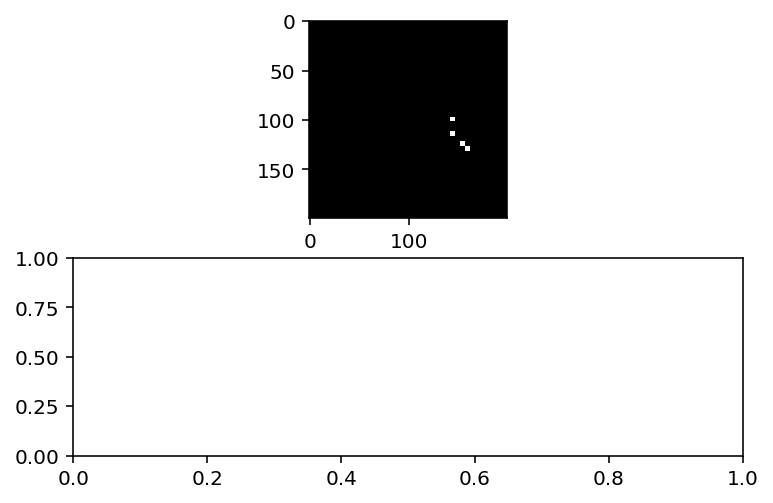

In [42]:
# ROTATE IMAGE
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


# FIND CENTRES
locs = np.array([[100,145], [125,155], [115,145], [130,160]])

# FIND ROTATION USING PCA
x = locs[:,0]
y = locs[:,1]
x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])
cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]
theta = np.arctan((x_v1)/(y_v1))  

# CHECK THAT HEAD ALWAYS UP
test_img = np.zeros((200,200,3),'float32')+np.nan
for k in range(locs.shape[0]):
    test_img[int(locs[k,0])-3:int(locs[k,0])+3,
             int(locs[k,1])-3:int(locs[k,1])+3] = k+1

ax=plt.subplot(2,1,1)
plt.imshow(test_img)

ax=plt.subplot(2,1,2)
test_img_rotated = rotate_image(test_img, -theta*180/3.14159)
plt.imshow(test_img_rotated)

# check if lower values are above higher values or vice versa
# convert to 1D array
test_img_1D = np.nansum(test_img_rotated,0)

plt.show()        